<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/AIChallenge003_%E7%94%BB%E5%83%8F%E3%81%AE%E6%B0%B4%E5%A2%97%E3%81%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備
## 0.1 ハードウェアアクセラレータの設定

1. [「AIChallenge001-画像の収集」を済ませておく](https://github.com/aquapathos/BasicAI/blob/master/AIChallenge001_%E7%94%BB%E5%83%8F%E3%81%AE%E5%8F%8E%E9%9B%86.ipynb)

2. [「ランタイム」メニューを開く]()
3. [「ランタイムのタイプを変更」をクリック]()
4. [[「ハードウェアアクセラレータ」で **GPU** を選択し，「保存」]()

<font color='green'>※ Google Colabは無料サービスを維持するため、利用者が多すぎるため GPU が使えない場合があります。その場合は時間がかかりますが、CPUでも実験は可能です。    
※ 同様に、複数セッションが許可されない場合があります。「セッションが多すぎます」と出た場合は他の起動中ランタイムを終了させてください。</font>

# 1. Google Drive をマウント
AIChallenge001 で保存した画像データを使うために Google Drive に接続します。

1. [次のセルを実行する]()
2. [リンクと入力フィールドが表示されるのでリンクをクリック]()
3. [アクセスリクエストを許可するとアクセス用のコードが表示されるのでコピー]()
4. [Enter your authorization code: フィールドに貼り付けて Enter]()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ２．　画像の読み込みと表示
##  2.1 関数定義
001 で使ったプログラムと同じです。　[次のセルを実行]() 



In [ ]:
import pickle
import os,math
import numpy as np
import matplotlib.pyplot as plt
    
# pickle 形式で保存された画像データの読み込み
def loadCategoryImages(fname, folder = "."):
    f = open(folder+"/"+fname,'rb')
    cat = pickle.load(f)
    f.close
    return cat

# 画像データの表示
# start番からnpic枚表示する関数を定義
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showimg(images, start = 0, npic = 48):
    n = npic if len(images) >= start+npic else len(images) - start
    plt.figure(figsize=(8,7.5*(math.ceil(n/8))/6),dpi=150)
    i = 0
    while True:
        if i < n :  
            plt.subplot((n-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[start+i][:,:,::-1])
            plt.title("{}".format(start+i))
            i += 1
        else:
            break

## 2.2 画像データの読み込みと内容確認

先に収集した画像データを読み込み、一部を表示して内容が同じか確認しておきます。　[次のセルを実行]() 

In [ ]:
GFOLDER = "drive/My Drive/LDATA"  # データ保存用のフォルダ名
c0img = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
c1img = loadCategoryImages("イヌ.pkl", folder=GFOLDER)
showimg(c0img,0,16)
showimg(c1img,0,16)

# データの水増し
**[ImageDataGenerator](https://keras.io/ja/preprocessing/image/)** を用いてデータを水増しする。

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import shutil
from glob import glob

def dataInflation1(inimg,num):

    datagen = ImageDataGenerator(
            rotation_range=0, # 画像をランダムに回転する
            width_shift_range=0.2, # ランダムに水平シフト
            height_shift_range=0.2, # ランダムに垂直シフト
            shear_range=5, # 剪断
            zoom_range=0.2, # ランダムにズームする範囲
            horizontal_flip=True, # 水平方向に入力をランダムに反転
            vertical_flip=True, # 垂直方向に入力をランダムに反転
            rescale=1.0 / 255, # 与えられた値をデータに積算する
            )
    
    # 出力先ディレクトリを作成
    tmpdir = "tmp/tmp"
    os.makedirs(tmpdir,exist_ok=True)
    inimg = inimg.reshape((1,) + inimg.shape)  # 次元を４次元に（ImageDataGeneratorの仕様)

    # 種となる画像から num+1 個のバリエーションを生成 
    g = datagen.flow(inimg, batch_size=1, save_to_dir=tmpdir, save_prefix='img', save_format='png')
    for i in range(num+1): # すべて成功すればnum-1個で良いのだが、稀に生成に失敗するので２つ余分に作っておく
        batch = g.next()

    pathes = glob(os.path.join(tmpdir, "*.png"))[:num-1]
    outimgs = [inimg.reshape(inimg.shape[1:])]
    for files in pathes:
        img = image.load_img(files)
        outimgs.append(np.array(img))
    shutil.rmtree(tmpdir)
    return np.array(outimgs)

def dataInflation(X,num):
    Xs = []
    for img in X:
        Xs.extend(dataInflation1(img,num=num))
    return Xs

### 動作確認


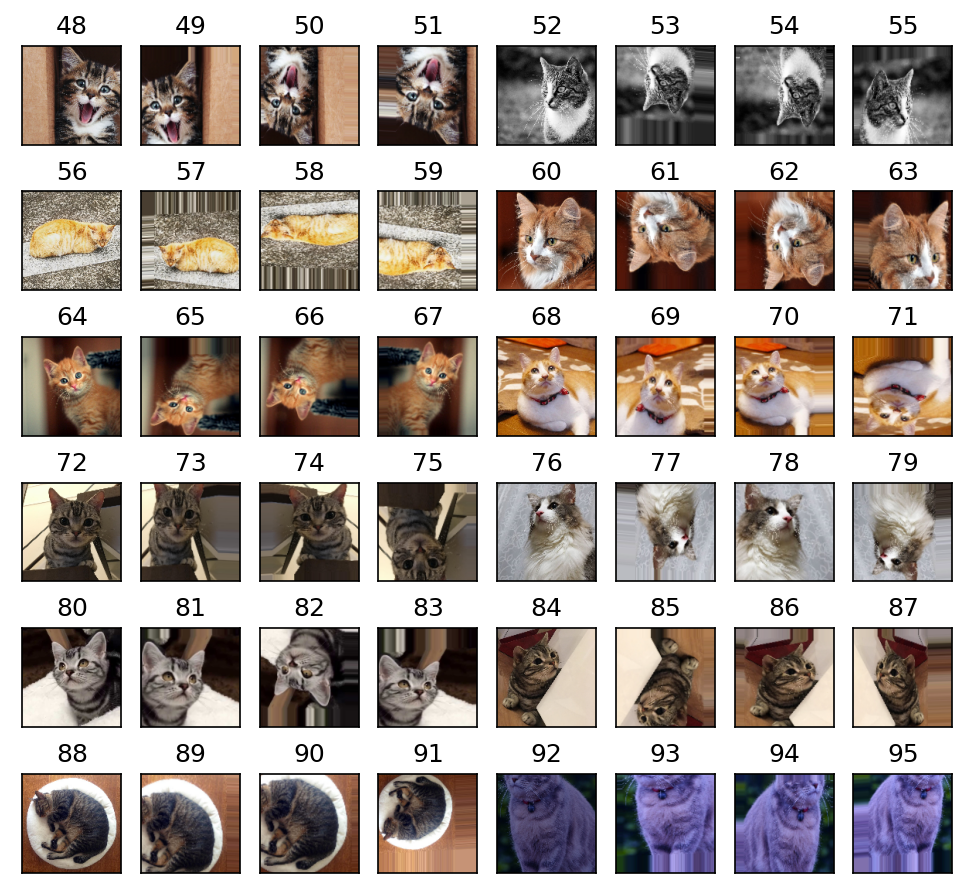

In [ ]:
IMG = dataInflation(c0img,4)
showimg(IMG,48)

# 3. 学習と認識の実験

## 3.1 学習モデル

水増しなしの時と同じなので説明省略

## 3.2 学習データの作成

画像データを訓練用とテスト用に分割し，学習用のデータをXtrainとXtestに分割します．

[次のセルを実行]() 

In [ ]:
#  変数の初期化

INFLATION = 24
def make_dataset(catalist):
    # catlist で与えられた画像データのリストから訓練用とテスト用のデータを作成し，
    # Xtrain (訓練用画像), ytrain（訓練例の正解)，Xtrain (テスト用画像), ytrain（テスト画像に対する)，NDATA（1カテゴリ当たりのデータ数）
    # 学習に用いるデータ数を、一番データ数の少ないカテゴリのデータ数に合わせる
    mindata = np.inf # 十分大きな数
    for cat in catalist:
        if len(cat) < mindata:
            mindata = len(cat)
    # ここに到達した時点で、mindata にはもっともデータ数の少ないカテゴリのデータ数が入っている
    NDATA = mindata
    threer = mindata%3
    NDATA = mindata - threer  #  個数を３の倍数となるよう調整

    Xtrain,Xtest = [],[]  # 入力画像のリスト
    ytrain,ytest = [],[]  #  ラベルのリスト
    for cimgs in catalist:
        Xtrain = Xtrain + cimgs[0:int(2*NDATA/3)]
        Xtest = Xtest + cimgs[int(2*NDATA/3):NDATA]
    # 訓練用データXtrainをINFLATION倍に水増し
    Xtrain = dataInflation(Xtrain,INFLATION)
    for label in range(len(catalist)):
        ytrain = ytrain + [label]*int(2*NDATA/3*INFLATION)
        ytest = ytest + [label]*int(NDATA/3)

    return Xtrain,ytrain,Xtest,ytest,NDATA

次のプログラムで，**CATALIST = [c1img,c2img]** の部分で認識対象となるカテゴリの画像データを指定する．カテゴリは２つである必要はなく，例えば，４つならば，

**CATALIST = [c1img,c2img,c3img,c4img]**   

等としてください．　[次のセルを実行]() 

In [ ]:
CATALIST = [c0img,c1img] # c0img:ネコ，c1img：イヌ
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytest)

カテゴリ数 2   1カテゴリ当たりのデータ数 81
訓練用 2592 テスト用 54  　データ総数 2646
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# model1  全結合２層ネットワーク

## モデル定義
[以下のセルを順に実行していってください．]() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


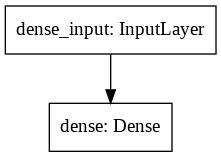

In [ ]:
# tensorflow2.x を前提としている。1.x の場合、tensorflow.keras を ただの keras に変える。
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Input, Activation, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger,TensorBoard

SIZE = 128

# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　2　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential()
model1.add(Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,)))

model1.summary()

from IPython.display import Image, display_png
#学習モデル図の作成
plot_model(model1, to_file='model1.png')
display_png(Image('model1.png'))

## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model1

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

In [ ]:
from matplotlib import cm
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss') # 誤差
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy') #  正解率
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別結果

In [ ]:
import pandas as pd

catnamelist = ['ネコ','イヌ']

# 訓練データに対する識別結果
def recognitionResult(Xdata, ydata, catnamelist=catnamelist):
    ndata = len(Xdata) # データ数
    predictT = model.predict(Xdata)
    predictT = [np.argmax(n1)  for n1 in predictT]
    NCAT = len(CATALIST) # カテゴリ数
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    Error = []
    for i in range(ndata):
        ct1[ydata[i],predictT[i]] += 1
        if ydata[i] != predictT[i]:
            Error.append([i,ydata[i],predictT[i]])
    print("誤認識データ（[データ番号, 正解, 認識結果]）\n {0} \n　正解率={1:5.1f}　誤り率＝{2:5.1f} %\n".format(Error,100*(ndata-len(Error))/ndata,100*len(Error)/ndata))
    print("正解カテゴリに対する認識結果と正解率")
    crossT1 = pd.concat([pd.DataFrame(catnamelist,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=catnamelist)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.round(1000*crossT1[cat][i]/ndata*NCAT)/10 for i,cat in enumerate(catnamelist)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')

    return Error, crossT1

TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[4, 0, 1], [7, 0, 1], [20, 0, 1], [24, 0, 1], [27, 0, 1], [28, 0, 1], [31, 0, 1], [32, 0, 1], [33, 0, 1], [42, 0, 1], [47, 0, 1], [77, 0, 1], [109, 0, 1], [111, 0, 1], [124, 0, 1], [144, 0, 1], [145, 0, 1], [146, 0, 1], [151, 0, 1], [153, 0, 1], [154, 0, 1], [155, 0, 1], [156, 0, 1], [158, 0, 1], [160, 0, 1], [162, 0, 1], [163, 0, 1], [164, 0, 1], [166, 0, 1], [167, 0, 1], [168, 0, 1], [171, 0, 1], [172, 0, 1], [173, 0, 1], [175, 0, 1], [177, 0, 1], [181, 0, 1], [183, 0, 1], [185, 0, 1], [186, 0, 1], [187, 0, 1], [190, 0, 1], [191, 0, 1], [193, 0, 1], [195, 0, 1], [197, 0, 1], [198, 0, 1], [200, 0, 1], [203, 0, 1], [205, 0, 1], [211, 0, 1], [212, 0, 1], [216, 0, 1], [221, 0, 1], [224, 0, 1], [248, 0, 1], [251, 0, 1], [256, 0, 1], [262, 0, 1], [265, 0, 1], [268, 0, 1], [269, 0, 1], [270, 0, 1], [274, 0, 1], [280, 0, 1], [281, 0, 1], [284, 0, 1], [286, 0, 1], [289, 0, 1], [295, 0, 1], [297, 0, 1], [298, 0, 1], [300, 0, 1], [301, 0, 1], [304, 0, 1], [306, 0, 1]

,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,921,375,71.1
イヌ,239,1057,81.6


In [ ]:
# 認識間違いの表示
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showEimg(errlist, images):
    last = len(errlist) if len(errlist) < 48 else 48
    if last == 0 : return
    plt.figure(figsize=(8,7.5*(math.ceil(last/8))/6),dpi=150)
    for i in range(last):
            plt.subplot((last-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[errlist[i][0]][:,:,::-1])
            plt.title("{}→{}".format(errlist[i][1],errlist[i][2]))

# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [2, 0, 1], [5, 0, 1], [9, 0, 1], [10, 0, 1], [12, 0, 1], [13, 0, 1], [14, 0, 1], [18, 0, 1], [19, 0, 1], [21, 0, 1], [23, 0, 1], [26, 0, 1], [28, 1, 0], [30, 1, 0], [31, 1, 0], [32, 1, 0], [33, 1, 0], [37, 1, 0], [41, 1, 0], [43, 1, 0], [49, 1, 0], [50, 1, 0]] 
　正解率= 57.4　誤り率＝ 42.6 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,14,13,51.9
イヌ,10,17,63.0


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# model 2　　３層全結合バックプロパゲーションネットワーク（中間層1024ノード）

## モデル定義

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              50332672  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 50,334,722
Trainable params: 50,334,722
Non-trainable params: 0
_________________________________________________________________


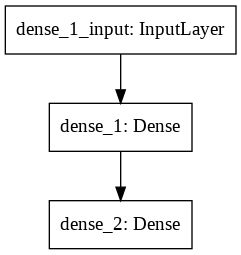

In [ ]:
# Model 2

model2 = Sequential()
model2.add(Dense(1024,activation='relu',input_shape=(DATASIZE,)))
# model2.add(Dropout(rate=0.5))
model2.add(Dense(CLASSES, activation='softmax'))

model2.summary()

#学習モデル図の作成
plot_model(model2, to_file='model2.png')
display_png(Image('model2.png'))

## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model2

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=200,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [4, 0, 1], [7, 0, 1], [8, 0, 1], [10, 0, 1], [14, 0, 1], [16, 0, 1], [19, 0, 1], [20, 0, 1], [27, 0, 1], [33, 0, 1], [47, 0, 1], [77, 0, 1], [145, 0, 1], [156, 0, 1], [164, 0, 1], [166, 0, 1], [168, 0, 1], [171, 0, 1], [174, 0, 1], [175, 0, 1], [177, 0, 1], [181, 0, 1], [183, 0, 1], [185, 0, 1], [186, 0, 1], [195, 0, 1], [204, 0, 1], [212, 0, 1], [216, 0, 1], [218, 0, 1], [221, 0, 1], [223, 0, 1], [224, 0, 1], [226, 0, 1], [235, 0, 1], [237, 0, 1], [238, 0, 1], [269, 0, 1], [274, 0, 1], [281, 0, 1], [286, 0, 1], [304, 0, 1], [307, 0, 1], [341, 0, 1], [343, 0, 1], [393, 0, 1], [402, 0, 1], [403, 0, 1], [414, 0, 1], [418, 0, 1], [428, 0, 1], [456, 0, 1], [457, 0, 1], [458, 0, 1], [459, 0, 1], [462, 0, 1], [463, 0, 1], [464, 0, 1], [465, 0, 1], [466, 0, 1], [467, 0, 1], [468, 0, 1], [469, 0, 1], [471, 0, 1], [472, 0, 1], [474, 0, 1], [476, 0, 1], [477, 0, 1], [478, 0, 1], [489, 0, 1], [499, 0, 1], [502, 0, 1], [590, 0, 1], [614, 0, 1], [638, 0, 1], [

,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,1158,138,89.4
イヌ,134,1162,89.7


誤認識したデータ


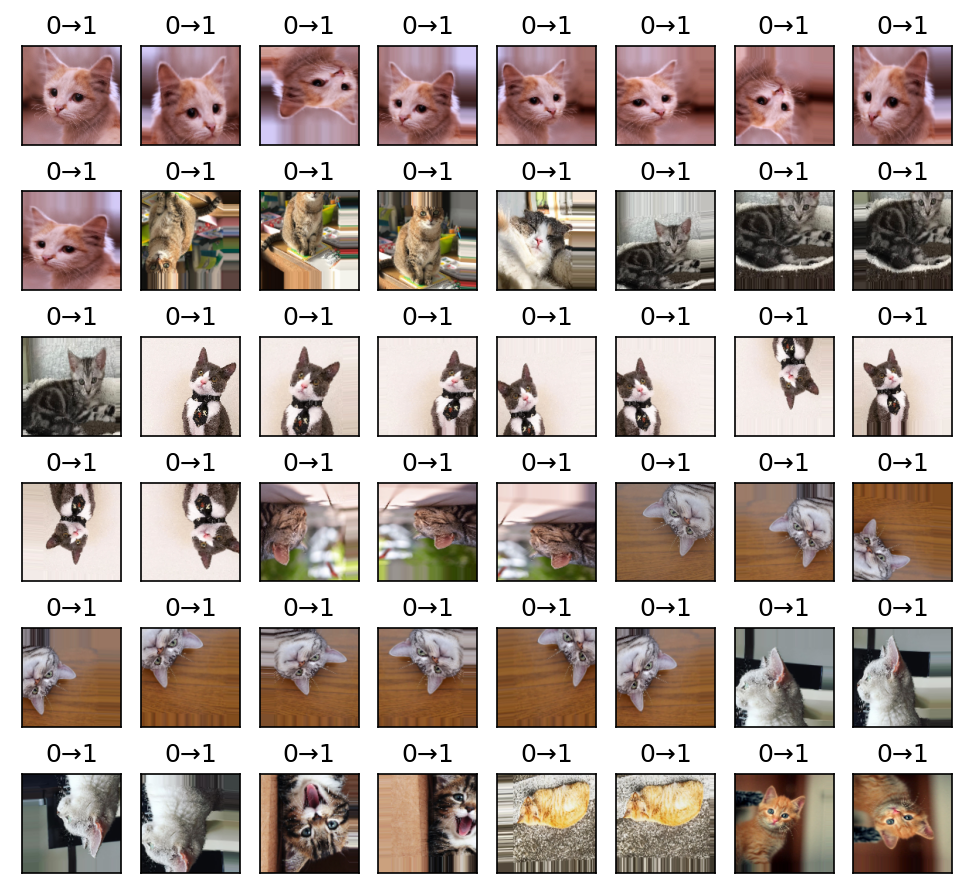

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [2, 0, 1], [5, 0, 1], [8, 0, 1], [9, 0, 1], [10, 0, 1], [12, 0, 1], [13, 0, 1], [14, 0, 1], [16, 0, 1], [18, 0, 1], [19, 0, 1], [20, 0, 1], [21, 0, 1], [22, 0, 1], [23, 0, 1], [24, 0, 1], [26, 0, 1], [32, 1, 0], [33, 1, 0], [37, 1, 0], [43, 1, 0], [49, 1, 0]] 
　正解率= 55.6　誤り率＝ 44.4 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,8,19,29.6
イヌ,5,22,81.5


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# model 3  CNN(畳み込みネットワーク）

## モデル定義

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

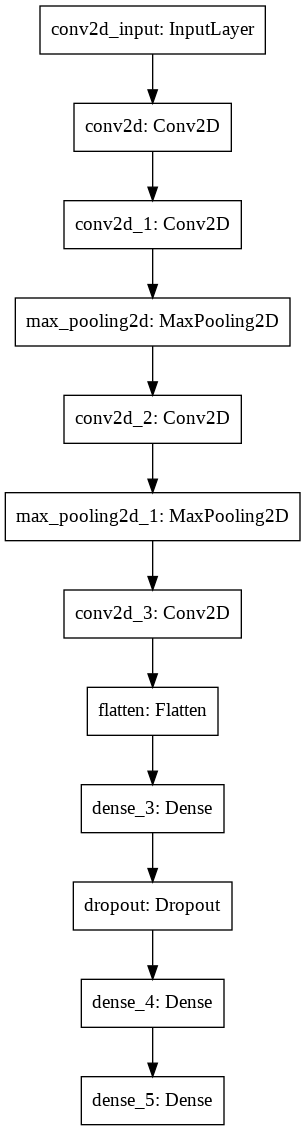

In [ ]:
# Model ３

model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 64 x 64 x 64
model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  #  32 x 32 x 128
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(CLASSES, activation='softmax'))

model3.summary()
model3.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

#学習モデル図の作成
plot_model(model3, to_file='model3.png')
display_png(Image('model3.png'))


## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model3

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

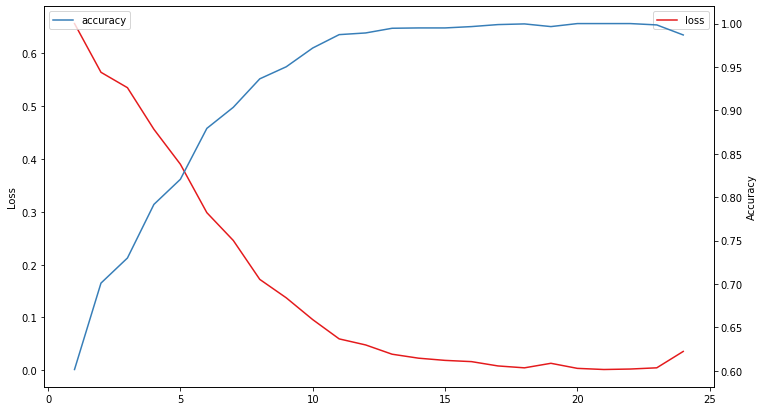

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1409, 1, 0], [1785, 1, 0], [2373, 1, 0], [2503, 1, 0], [2507, 1, 0]] 
　正解率= 99.8　誤り率＝  0.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,1296,0,100.0
イヌ,5,1291,99.6


誤認識したデータ


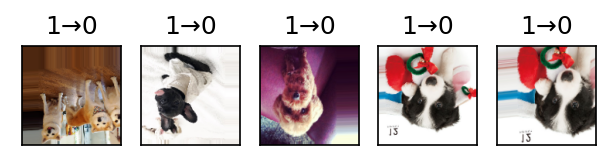

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [2, 0, 1], [5, 0, 1], [10, 0, 1], [14, 0, 1], [19, 0, 1], [20, 0, 1], [25, 0, 1], [29, 1, 0], [30, 1, 0], [31, 1, 0], [32, 1, 0], [37, 1, 0], [40, 1, 0], [42, 1, 0], [43, 1, 0], [45, 1, 0], [46, 1, 0], [49, 1, 0], [51, 1, 0]] 
　正解率= 61.1　誤り率＝ 38.9 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,18,9,66.7
イヌ,12,15,55.6


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# ネコとカメ

イヌの代わりにカメで同じ実験をやってみましょう．

In [ ]:
# c0img = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
c2img = loadCategoryImages("カメ.pkl", folder=GFOLDER)
showimg(c0img,0,16)
showimg(c2img,0,16)

In [ ]:
catnamelist = ['ネコ','カメ']
CATALIST=[c0img,c2img] # c0img:ネコ, c2img:カメ

# 訓練用とテスト用に分割
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認 (ytrainは多すぎるので ytest のみ表示)
print(ytest)

カテゴリ数 2   1カテゴリ当たりのデータ数 102
訓練用 3264 テスト用 68  　データ総数 3332
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## model1

In [ ]:
# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　2　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential()
model1.add(Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,)))

model = model1
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
from matplotlib import cm
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss') # 誤差
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy') #  正解率
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[27, 0, 1], [38, 0, 1], [74, 0, 1], [80, 0, 1], [110, 0, 1], [145, 0, 1], [153, 0, 1], [154, 0, 1], [158, 0, 1], [161, 0, 1], [162, 0, 1], [168, 0, 1], [181, 0, 1], [197, 0, 1], [200, 0, 1], [266, 0, 1], [271, 0, 1], [322, 0, 1], [326, 0, 1], [340, 0, 1], [343, 0, 1], [347, 0, 1], [432, 0, 1], [436, 0, 1], [438, 0, 1], [441, 0, 1], [446, 0, 1], [453, 0, 1], [454, 0, 1], [459, 0, 1], [463, 0, 1], [470, 0, 1], [471, 0, 1], [472, 0, 1], [480, 0, 1], [485, 0, 1], [488, 0, 1], [497, 0, 1], [499, 0, 1], [507, 0, 1], [508, 0, 1], [516, 0, 1], [519, 0, 1], [524, 0, 1], [525, 0, 1], [529, 0, 1], [547, 0, 1], [605, 0, 1], [607, 0, 1], [616, 0, 1], [624, 0, 1], [625, 0, 1], [630, 0, 1], [631, 0, 1], [632, 0, 1], [638, 0, 1], [639, 0, 1], [640, 0, 1], [641, 0, 1], [642, 0, 1], [643, 0, 1], [644, 0, 1], [645, 0, 1], [647, 0, 1], [651, 0, 1], [653, 0, 1], [654, 0, 1], [657, 0, 1], [677, 0, 1], [679, 0, 1], [681, 0, 1], [688, 0, 1], [690, 0, 1], [698, 0, 1], [716, 0, 1], [

,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,1391,241,85.2
カメ,505,1127,69.1


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [3, 0, 1], [9, 0, 1], [10, 0, 1], [11, 0, 1], [12, 0, 1], [21, 0, 1], [28, 0, 1], [29, 0, 1], [30, 0, 1], [37, 1, 0], [38, 1, 0], [49, 1, 0], [51, 1, 0], [52, 1, 0], [53, 1, 0], [57, 1, 0], [61, 1, 0], [65, 1, 0], [66, 1, 0]] 
　正解率= 70.6　誤り率＝ 29.4 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,24,10,70.6
カメ,10,24,70.6


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## model2

In [ ]:
# Model 2

model2 = Sequential()
model2.add(Dense(1024,activation='relu',input_shape=(DATASIZE,)))
# model2.add(Dropout(rate=0.5))
model2.add(Dense(CLASSES, activation='softmax'))

model = model2
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,1632,0,100.0
カメ,0,1632,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [2, 0, 1], [6, 0, 1], [8, 0, 1], [9, 0, 1], [10, 0, 1], [11, 0, 1], [12, 0, 1], [13, 0, 1], [14, 0, 1], [16, 0, 1], [17, 0, 1], [18, 0, 1], [20, 0, 1], [23, 0, 1], [24, 0, 1], [25, 0, 1], [27, 0, 1], [28, 0, 1], [29, 0, 1], [31, 0, 1], [37, 1, 0], [45, 1, 0], [47, 1, 0], [52, 1, 0], [53, 1, 0], [60, 1, 0], [61, 1, 0], [66, 1, 0], [67, 1, 0]] 
　正解率= 55.9　誤り率＝ 44.1 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,13,21,38.2
カメ,9,25,73.5


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

# model3

In [ ]:
# Model ３

model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 64 x 64 x 64
model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  #  32 x 32 x 128
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(CLASSES, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

model = model3
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

# 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[554, 0, 1], [560, 0, 1], [2149, 1, 0], [2150, 1, 0], [2399, 1, 0]] 
　正解率= 99.8　誤り率＝  0.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,1630,2,99.9
カメ,3,1629,99.8


誤認識したデータ


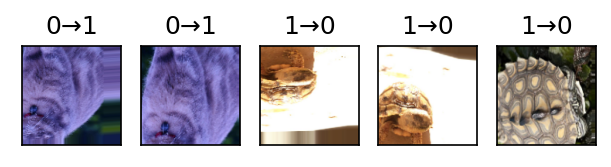

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[8, 0, 1], [11, 0, 1], [15, 0, 1], [21, 0, 1], [30, 0, 1], [38, 1, 0], [47, 1, 0], [52, 1, 0], [53, 1, 0], [58, 1, 0], [65, 1, 0]] 
　正解率= 83.8　誤り率＝ 16.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,29,5,85.3
カメ,6,28,82.4


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

# ネコ，イヌ，カメ

## データの準備

In [ ]:
catnamelist = ['ネコ','イヌ','カメ']
CATALIST=[c0img,c1img,c2img] # c0img:ネコ, c1img:イヌ，c2img:カメ

# 訓練用とテスト用に分割
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytest)

カテゴリ数 3   1カテゴリ当たりのデータ数 81
訓練用 3888 テスト用 81  　データ総数 3969
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　３　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential()
model1.add(Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,)))

model = model1
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

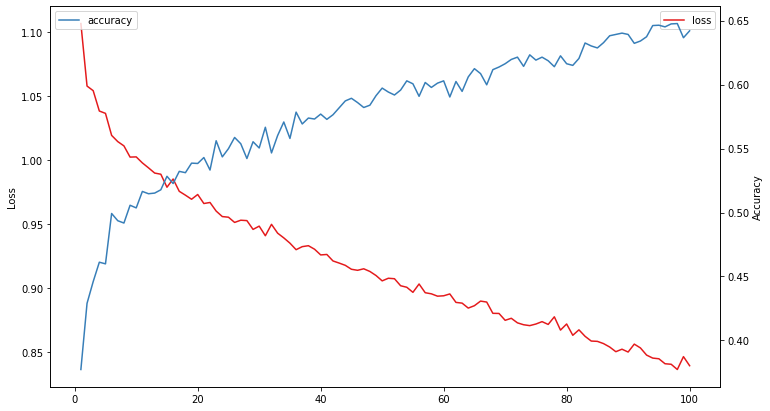

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [4, 0, 1], [9, 0, 1], [11, 0, 1], [14, 0, 1], [15, 0, 1], [21, 0, 1], [33, 0, 2], [35, 0, 2], [37, 0, 2], [39, 0, 2], [41, 0, 2], [46, 0, 2], [78, 0, 1], [90, 0, 2], [93, 0, 1], [95, 0, 2], [122, 0, 1], [144, 0, 1], [146, 0, 1], [147, 0, 2], [148, 0, 1], [149, 0, 1], [151, 0, 1], [152, 0, 1], [153, 0, 2], [154, 0, 1], [157, 0, 2], [159, 0, 2], [160, 0, 2], [161, 0, 1], [162, 0, 2], [165, 0, 2], [167, 0, 2], [168, 0, 2], [169, 0, 1], [170, 0, 1], [171, 0, 1], [172, 0, 2], [174, 0, 1], [175, 0, 1], [177, 0, 1], [179, 0, 2], [181, 0, 1], [182, 0, 1], [183, 0, 1], [185, 0, 1], [186, 0, 1], [187, 0, 1], [188, 0, 1], [189, 0, 1], [190, 0, 1], [191, 0, 1], [192, 0, 1], [194, 0, 1], [195, 0, 2], [196, 0, 1], [199, 0, 1], [201, 0, 1], [202, 0, 1], [204, 0, 1], [210, 0, 1], [213, 0, 1], [215, 0, 1], [218, 0, 1], [219, 0, 1], [232, 0, 1], [242, 0, 2], [243, 0, 1], [246, 0, 1], [248, 0, 1], [260, 0, 1], [262, 0, 1], [263, 0, 1], [269, 0, 1], [272, 0, 2], [278

,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,814,300,182,62.8
イヌ,206,921,169,71.1
カメ,208,244,844,65.1


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [2, 0, 2], [3, 0, 1], [5, 0, 1], [6, 0, 2], [8, 0, 1], [9, 0, 1], [10, 0, 2], [11, 0, 2], [12, 0, 2], [13, 0, 1], [14, 0, 1], [15, 0, 2], [16, 0, 1], [17, 0, 2], [19, 0, 1], [20, 0, 1], [21, 0, 1], [23, 0, 1], [26, 0, 1], [27, 1, 2], [28, 1, 0], [29, 1, 0], [30, 1, 0], [31, 1, 0], [32, 1, 0], [33, 1, 2], [34, 1, 2], [37, 1, 0], [39, 1, 2], [41, 1, 2], [42, 1, 0], [43, 1, 0], [44, 1, 2], [47, 1, 2], [49, 1, 0], [52, 1, 2], [54, 2, 1], [56, 2, 0], [57, 2, 0], [58, 2, 0], [59, 2, 0], [60, 2, 0], [62, 2, 1], [63, 2, 1], [64, 2, 1], [67, 2, 0], [71, 2, 1], [75, 2, 1], [77, 2, 1], [78, 2, 0], [79, 2, 0]] 
　正解率= 35.8　誤り率＝ 64.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,7,13,7,25.9
イヌ,9,10,8,37.0
カメ,8,7,12,44.4


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# model2

In [ ]:
# Model 2

model2 = Sequential()
model2.add(Dense(1024,activation='relu',input_shape=(DATASIZE,)))
# model2.add(Dropout(rate=0.5))
model2.add(Dense(CLASSES, activation='softmax'))

model = model2
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[462, 0, 1], [1299, 1, 0], [1304, 1, 0], [1305, 1, 0], [1307, 1, 0], [1308, 1, 0], [1310, 1, 0], [1312, 1, 0], [1313, 1, 0], [1318, 1, 0], [1321, 1, 0], [1323, 1, 0], [1327, 1, 0], [1328, 1, 2], [1329, 1, 0], [1334, 1, 0], [1335, 1, 0], [1340, 1, 0], [1347, 1, 0], [1349, 1, 0], [1350, 1, 0], [1353, 1, 0], [1355, 1, 0], [1356, 1, 0], [1357, 1, 0], [1358, 1, 0], [1359, 1, 0], [1361, 1, 0], [1364, 1, 0], [1365, 1, 0], [1367, 1, 0], [1370, 1, 0], [1372, 1, 0], [1373, 1, 0], [1379, 1, 0], [1382, 1, 0], [1383, 1, 0], [1384, 1, 0], [1390, 1, 0], [1398, 1, 0], [1405, 1, 0], [1407, 1, 0], [1411, 1, 0], [1414, 1, 0], [1421, 1, 0], [1430, 1, 0], [1467, 1, 0], [1483, 1, 0], [1488, 1, 0], [1489, 1, 0], [1491, 1, 0], [1494, 1, 0], [1495, 1, 0], [1496, 1, 0], [1500, 1, 0], [1508, 1, 0], [1516, 1, 0], [1517, 1, 0], [1525, 1, 0], [1526, 1, 0], [1531, 1, 0], [1534, 1, 0], [1535, 1, 0], [1539, 1, 0], [1583, 1, 0], [1591, 1, 0], [1607, 1, 0], [1609, 1, 0], [1619, 1, 0], [1625, 

,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,1295,1,0,99.9
イヌ,232,1062,2,81.9
カメ,9,0,1287,99.3


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 2], [2, 0, 1], [3, 0, 2], [5, 0, 1], [6, 0, 2], [8, 0, 2], [10, 0, 2], [12, 0, 2], [15, 0, 2], [16, 0, 1], [19, 0, 2], [20, 0, 1], [21, 0, 1], [23, 0, 1], [26, 0, 2], [27, 1, 0], [28, 1, 0], [29, 1, 0], [30, 1, 0], [32, 1, 0], [33, 1, 2], [34, 1, 2], [37, 1, 0], [39, 1, 2], [42, 1, 0], [43, 1, 0], [45, 1, 0], [47, 1, 0], [49, 1, 0], [52, 1, 0], [59, 2, 0], [60, 2, 0], [62, 2, 1], [64, 2, 0], [65, 2, 0], [66, 2, 0], [67, 2, 0], [71, 2, 1], [73, 2, 1], [74, 2, 0], [77, 2, 1], [78, 2, 0], [79, 2, 0]] 
　正解率= 46.9　誤り率＝ 53.1 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,12,6,9,44.4
イヌ,12,12,3,44.4
カメ,9,4,14,51.9


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# model3

In [ ]:
# Model ３

model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  # 64 x 64 x 64
model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))  #  32 x 32 x 128
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(CLASSES, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

model = model3
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

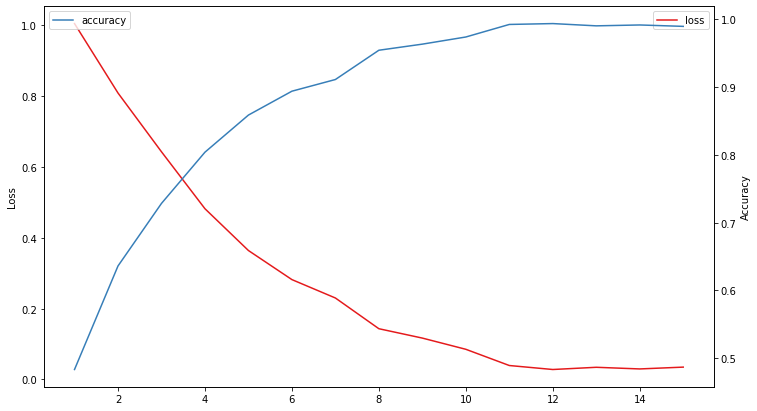

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

# 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[354, 0, 2], [356, 0, 2]] 
　正解率= 99.9　誤り率＝  0.1 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,1294,0,2,99.8
イヌ,0,1296,0,100.0
カメ,0,0,1296,100.0


誤認識したデータ


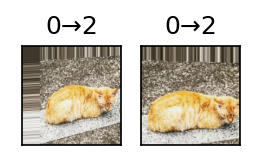

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 2], [2, 0, 1], [5, 0, 1], [8, 0, 2], [9, 0, 2], [10, 0, 1], [12, 0, 2], [13, 0, 1], [16, 0, 2], [19, 0, 2], [20, 0, 1], [21, 0, 2], [23, 0, 2], [25, 0, 1], [26, 0, 1], [29, 1, 0], [30, 1, 0], [32, 1, 0], [33, 1, 2], [34, 1, 0], [39, 1, 2], [42, 1, 0], [43, 1, 0], [45, 1, 0], [48, 1, 2], [49, 1, 0], [50, 1, 0], [51, 1, 2], [52, 1, 2], [60, 2, 0], [65, 2, 0], [71, 2, 0]] 
　正解率= 59.3　誤り率＝ 40.7 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,11,8,8,40.7
イヌ,9,13,5,48.1
カメ,3,0,24,88.9


誤認識したデータ


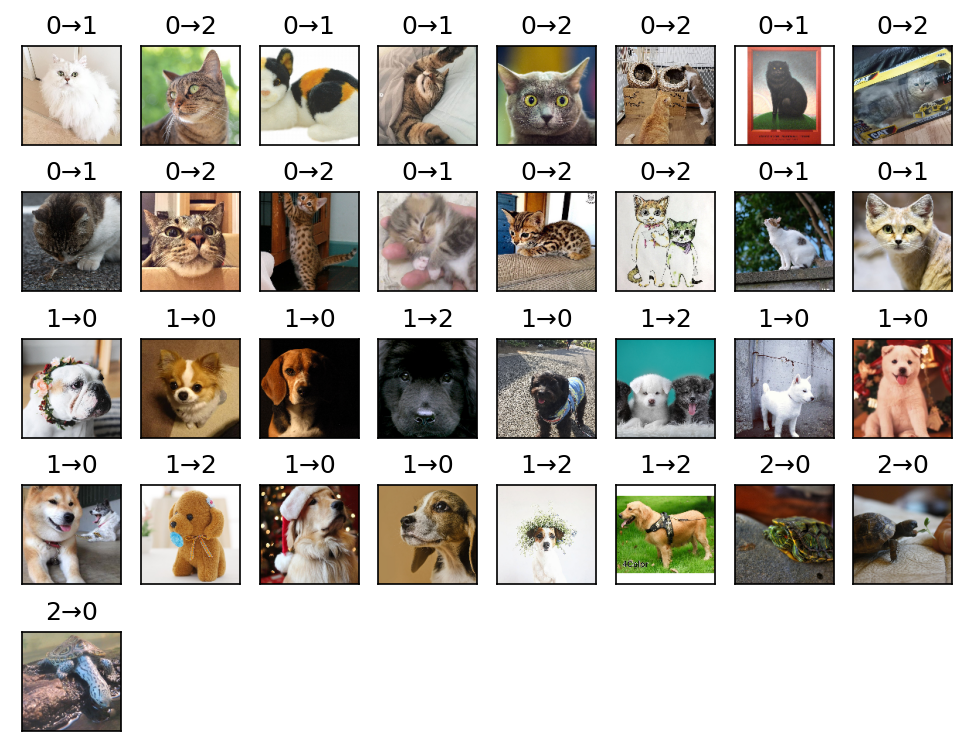

In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# 課題

**自分で選んだカテゴリ（３ないし４）で、水増しなしと水増しありの結果を比較しなさい。**


余裕があれば次のような追加実験をしましょう．同じ実験を何度か繰り返し，同じ傾向がみられるかどうか検証すること。
